In [17]:
pip install arch

   ---------------------------------------- 0.0/924.9 kB ? eta -:--:--
   - -------------------------------------- 30.7/924.9 kB 1.3 MB/s eta 0:00:01
   ---- ----------------------------------- 112.6/924.9 kB 1.6 MB/s eta 0:00:01
   -------------- ------------------------- 327.7/924.9 kB 2.9 MB/s eta 0:00:01
   ---------------------- ----------------- 522.2/924.9 kB 3.3 MB/s eta 0:00:01
   ---------------------------- ----------- 655.4/924.9 kB 3.4 MB/s eta 0:00:01
   ---------------------------------------  921.6/924.9 kB 3.6 MB/s eta 0:00:01
   ---------------------------------------- 924.9/924.9 kB 3.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [11]:
#import data

import pandas as pd
import numpy as np
from scipy import stats
from scipy.optimize import minimize
from arch import arch_model
import math
import scipy
import statsmodels.tsa.stattools
import sympy as sp #for solving an equation involving autocorrelation of epsilon^2 for alpha0 and beta0, which are in turn for 
#from scipy.stats import norm

import matplotlib.pyplot as plt
from autograd import grad, hessian
import autograd.numpy as anp

HSI = pd.read_csv("^HSI_2.csv")
HSI['Date'] = pd.to_datetime(HSI['Date'])
HSI['returns'] = np.log(HSI['Close']) - np.log(HSI['Close'].shift(1))
HSI.dropna(inplace = True)
HSI

,Date,Open,High,Low,Close,Adj Close,Volume,returns
1,2010-08-10,21764.230469,21765.580078,21446.800781,21473.599609,21473.599609,1.257248e+09,-0.015159
2,2010-08-11,21542.269531,21643.240234,21239.169922,21294.539063,21294.539063,1.475898e+09,-0.008374
3,2010-08-12,21039.419922,21124.980469,20926.480469,21105.710938,21105.710938,1.695693e+09,-0.008907
4,2010-08-13,21095.169922,21205.679688,21012.509766,21071.570313,21071.570313,1.230389e+09,-0.001619
5,2010-08-16,20881.949219,21209.460938,20881.949219,21112.119141,21112.119141,1.053816e+09,0.001922
...,...,...,...,...,...,...,...,...
3450,2024-08-05,16676.820313,16944.589844,16441.439453,16698.359375,16698.359375,3.667471e+09,-0.014692
3451,2024-08-06,16861.300781,16908.970703,16611.140625,16647.339844,16647.339844,2.425958e+09,-0.003060
3452,2024-08-07,16684.779297,16988.259766,16684.779297,16877.859375,16877.859375,2.267420e+09,0.013752
3453,2024-08-08,16773.039063,17023.099609,16665.060547,16891.830078,16891.830078,2.114356e+09,0.000827


The following code plots the histogram of the log return series. It can be seen that the left tail is heavier than the right tail and this is a common phenomenon for return series of stock.
The normality test shows that the normality assumption is highly questionable as reflected by the very small p-value.

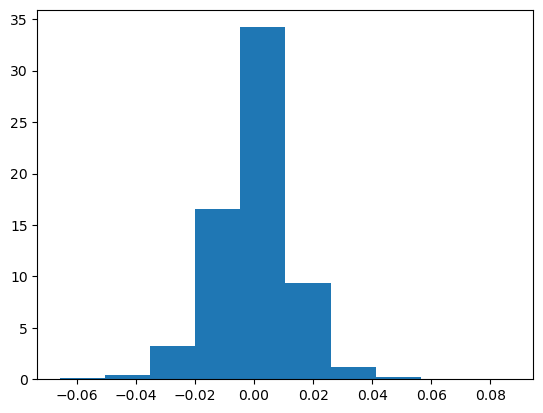

NormaltestResult(statistic=243.49661585730232, pvalue=1.334693930512661e-53)

In [12]:
plt.hist(HSI['returns'], density=True)
plt.show()
stats.normaltest(HSI['returns'])

In [13]:
#Split the data set into insample and outsample
HSI_insample = HSI[HSI['Date']<='2017-12-31']

HSI_outsample = HSI[HSI['Date']>='2018-01-01']


For GARCH(1,1) model
\begin{align*}
\epsilon_{t} & =\sigma_{t}\eta_{t},\\
\sigma_{t}^{2} & =\omega+\alpha\epsilon_{t-1}^{2}+\beta\sigma_{t-1}^{2},
\end{align*}
it can be shown that the lag 1 autocorrelation of the process $\left\{ \epsilon_{t}^{2}\right\} $
is
$$\rho_{\epsilon_{t}^{2}}\left(1\right)=\frac{\alpha\left(1-\beta^{2}-\alpha\beta\right)}{1-\beta^{2}-2\alpha\beta}$$
and the autocorrelation function at other lags $h>1$ satisfies
$$\rho_{\epsilon_{t}^{2}}\left(h\right)=\left(\alpha+\beta\right)\rho_{\epsilon_{t}^{2}}\left(h-1\right).$$
With the sample autocorrelations at lag 1, lag 2 and lag 3, we can
obtain a system of equations in terms of $\alpha$ and $\beta$
\[
\begin{cases}
\rho_{\epsilon_{t}^{2}}\left(1\right) & =\frac{\alpha\left(1-\beta^{2}-\alpha\beta\right)}{1-\beta^{2}-2\alpha\beta}\\
\frac{\rho_{\epsilon_{t}^{2}}\left(2\right)}{\rho_{\epsilon_{t}^{2}}\left(1\right)} & =\alpha+\beta
\end{cases}
\]
and solve for $\alpha$ and $\beta$, which can serve as initial values
for the numerical maximization of the log-likelihood function.

In [14]:
###This part of codes uses the sample autocorrelations of the squared return to compute the value of alpha and beta,
###which serve as the initial values for the numerical maximization of the log-likelihood function.

#compute the squared return
return_square = HSI['returns']**2

#compute the autocorrelations of squared return
rho = statsmodels.tsa.stattools.acf(return_square)

# Define the variable alpha
alpha = sp.symbols('alpha')

#set the rho1 as the autocorrelation at lag 1
rho1 = rho[1]

#set the rho2rho1 as the ratio of autocorrelation at lag 2 to autocorrelation at lag 1
rho2rho1 = rho[2]/rho[1]
# Define the equation. We have the equation beta = rho2/rho1 - alpha. Substitute it into the 
equation = sp.Eq(rho1, alpha * (1 - (rho2rho1 - alpha)**2 - alpha*(rho2rho1 - alpha)) / (1 - (rho2rho1 - alpha)**2 - 2*alpha*(rho2rho1 - alpha)))

# Solve for alpha
solutions = sp.solve(equation, alpha)

#solutions is a list with one negative value and one positive value. Take the positive one.
#alpha0 and beta0 will serve as initial values for numerical maximization of the log-likelihood function.
for x in solutions:
    if x > 0:
        alpha0 = x
        beta0 = rho2rho1 - alpha0

#The log-likelihood function and the function for computing hessian are defined below.

#log-likelihood function
def garch_log_likelihood(params, returns, p, q):
    omega = params[0]
    alpha = params[1:p+1]
    beta = params[p+1: p+q+1]
    T = len(returns)
    sigma2 = np.zeros(T + max(p, q))
    epsilon = np.zeros(T + max(p, q))
    
    log_likelihood = 0
    
    sigma2[0: max(p, q)] = np.var(returns)
    epsilon[0: max(p, q)] = returns[0] #assume for the moment the ARMA order is (0,0) with no intercept

    returns = np.concatenate([np.zeros(max(p, q)), returns])

    log_likelihood = 0
    for t in range(max(p, q), T + max(p, q)):
        #print("t: ", t)
        sigma2_t = omega
        for i in range(1, p + 1):
            sigma2_t += alpha[i-1] * epsilon[t-i]**2

        for j in range(1, q + 1):
            sigma2_t += beta[j-1] * sigma2[t-j]

        sigma2[t] = sigma2_t
        #print("sigma2[t]: ", sigma2[t])
        epsilon[t] = returns[t]
        #print("epsilon[t[: ", epsilon[t])
        #print("")
        log_likelihood += -0.5 * (np.log(2 * np.pi) + np.log(sigma2[t]) + (epsilon[t]**2 / sigma2[t]))

    return -log_likelihood

#gradient of the log-likelihood function
def garch_log_likelihood_grad(params, returns, p, q):
    omega = params[0]
    alpha = params[1:p+1]
    beta = params[p+1: p+q+1]
    T = len(returns)
    sigma2 = np.zeros(T + max(p, q))
    epsilon = np.zeros(T + max(p, q))
    sigma2[0: max(p, q)] = np.var(returns)
    print('sigma2: ', sigma2)
    returns = np.concatenate([np.zeros(max(p, q)), returns])
    log_likelihood = 0
    dL = np.zeros(1+p+q) # 1st derivative of log-likelihood
    
    
    for t in range(max(p, q), T + max(p, q)):

        sigma2_t = omega
        for i in range(1, p + 1):
            sigma2_t += alpha[i-1] * epsilon[t-i]**2
            
        for j in range(1, q + 1):
            sigma2_t += beta[j-1] * sigma2[t-j]
        sigma2[t] = sigma2_t
        
        epsilon[t] = returns[t]

    dhdw = np.zeros((1+q+p, T+max(p,q)))

    
    for t in range(max(p, q), T + max(p ,q)):
        
        dhdw[:,t] = np.concatenate([[1], epsilon[t-q:t][::-1]**2, sigma2[t-p:t][::-1]]) + np.sum( dhdw[:, t-p:t][:, ::-1]*beta, axis = 1)
        dL += -0.5 * dhdw[:, t]*(1/sigma2[t] - epsilon[t]**2/sigma2[t]**2)

    return dL

#Hessian matrix of log-likelihood function
def garch_log_likelihood_hess(params, returns, p, q):
    omega = params[0]
    alpha = params[1:p+1]
    beta = params[p+1: p+q+1]
    T = len(returns)
    sigma2 = np.zeros(T + max(p, q))
    epsilon = np.zeros(T + max(p, q))
    sigma2[0: max(p, q)] = np.var(returns)
    #print('sigma2: ', sigma2)
    returns = np.concatenate([np.zeros(max(p, q)), returns])
    log_likelihood = 0
    dL2 = np.zeros((1+p+q, 1+p+q)) # 2nd derivative of log-likelihood
    
    
    for t in range(max(p, q), T + max(p, q)):

        sigma2_t = omega
        for i in range(1, p + 1):
            sigma2_t += alpha[i-1] * epsilon[t-i]**2
            
        for j in range(1, q + 1):
            sigma2_t += beta[j-1] * sigma2[t-j]
        sigma2[t] = sigma2_t
        
        epsilon[t] = returns[t]

    dhdw = np.zeros((1+q+p, T+max(p,q)))

    
    for t in range(max(p, q), T + max(p ,q)):
        
        dhdw[:,t] = np.concatenate([[1], epsilon[t-q:t][::-1]**2, sigma2[t-p:t][::-1]]) + np.sum( dhdw[:, t-p:t][:, ::-1]*beta, axis = 1)
        #dL += -0.5 * dhdw[:, t]*(1/sigma2[t] - epsilon[t]**2/sigma2[t]**2)

    d2hdw2 = np.zeros((T+max(p,q), 1+q+p, 1+q+p))
    #print("d2hdw2: ", d2hdw2)
    for t in range(max(p, q), T + max(p ,q)):
        #print("t: ", t)
        #print("1st: ", np.append(np.zeros((q+1, p+q+1)), dhdw[:,t-p:t][:, ::-1].T, axis = 0))
        #print(np.append(np.zeros((q+1, p+q+1)), dhdw[:,t-p:t][:, ::-1].T, axis = 0).shape)
        #print("2nd: ", np.append(np.zeros((q+1, p+q+1)), dhdw[:,t-p:t][:, ::-1].T, axis = 0).T)
        #print(np.append(np.zeros((q+1, p+q+1)), dhdw[:,t-p:t][:, ::-1].T, axis = 0).T.shape)
        #print("3rd: ", np.sum(d2hdw2[t-p:t][::-1]*beta[:, np.newaxis, np.newaxis], axis = 0 ))
        #print(np.sum(d2hdw2[t-p:t][::-1]*beta[:, np.newaxis, np.newaxis], axis = 0 ).shape)
        d2hdw2[t,:,:] = np.append(np.zeros((q+1, p+q+1)), dhdw[:,t-p:t][:, ::-1].T, axis = 0) + \
                        np.append(np.zeros((q+1, p+q+1)), dhdw[:,t-p:t][:, ::-1].T, axis = 0).T + \
                        np.sum(d2hdw2[t-p:t][::-1]*beta[:, np.newaxis, np.newaxis], axis = 0 )
        #print("d2hdw2[t,:,:] ", d2hdw2[t,:,:])
        #print("3rd: ", d2hdw2)
        dL2 += -0.5 * ( (-1/sigma2[t]**2 + 2*epsilon[t]**2/sigma2[t]**3) * dhdw[:,t][:, np.newaxis] @ dhdw[:,t][np.newaxis, :] \
                       +(1/sigma2[t]-epsilon[t]**2/sigma2[t]**2) * d2hdw2[t,:,:]      )
        #print("dL2.shape: ", dL2.shape)
    return dL2

#Choose the order p and q
p = 1
q = 1

#Initial values of the model parameters for minimization of negative of log-likelihood function
initial_params = [0.000003] + [alpha0]*p + [beta0]*q

#Define the bounds of the parameters
bounds = [ (1e-6, None) ] + [(0, 1)]*p + [(0, 1)]*q

#Fit a GARCH(1,1) model to the in-sample by minimizing the negative of log-likelihood
result = minimize(garch_log_likelihood, initial_params, args=(HSI_insample["returns"].values, p, q), method='L-BFGS-B', bounds=bounds)

# Estimated parameters
estimated_params = result.x
omega_est, alpha_est, beta_est = estimated_params

# Compute standard errors of the estimates
# The standard errors can be approximated from the Hessian matrix
hess = garch_log_likelihood_hess(result.x, HSI_insample["returns"].values, p, q)
Fisher_info = -hess
std_errors = np.sqrt(np.diag(np.linalg.inv(Fisher_info)))

# Print the results
print(f"Estimated omega: {omega_est}, Standard Error: {std_errors[0]}")
print(f"Estimated alpha: {alpha_est}, Standard Error: {std_errors[1]}")
print(f"Estimated beta: {beta_est}, Standard Error: {std_errors[2]}")

print(f"success: {result.success}")
print(f"message: {result.message}")


maximized_loglikelihood = garch_log_likelihood(result.x, HSI_insample["returns"].values, p, q)
print(f"Maximized log-likelihood value: {maximized_loglikelihood}")

Estimated omega: 2.4997146203982606e-06, Standard Error: 9.83001866032699e-07
Estimated alpha: 0.05880489030246077, Standard Error: 0.01172190869135076
Estimated beta: 0.9207482176740402, Standard Error: 0.017708609911228187
success: True
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Maximized log-likelihood value: -5693.505713378558


Now, we can estimate 1-day value-at-risk using the fitted GARCH model.

1. With the fitted GARCH(1, 1) model on the observed returns $\epsilon_{t}$,
$t=1,\ldots,n$, we deduce the estimated volatility $\hat{\sigma}_{t}^{2}$
for $t=1,\ldots,n+1$.
2. Determine the $\alpha$-quantile $q_{\hat{\eta_{t}},t}\left(\alpha\right)$, where $\alpha$ is typically 0.01 or 0.05, of $\hat{\eta_{t}} = \frac{\epsilon_{t}}{\hat{\sigma_{t}}}$. The quantile can be determined by the empirical distribution of $\hat{\eta_{t}}$ or by assuming $\hat{\eta_{t}}$ follows a parametric distribution such as standard normal.
3. The $\alpha$-quantile of the future return $\epsilon_{t+1}$ is given by $q_{\epsilon_{t},t}\left(\alpha\right) = \hat{\sigma}_{t+1}^{2}q_{\hat{\eta_{t}},t}\left(\alpha\right)$ 
4. The value-at-risk on day $t+1$ is given by $\left\{ 1-e^{q_{\epsilon_{t},t}\left(\alpha\right)}\right\} p_{t}$, where $p_{t}$ is the closing price on day $t$

In the following cells, comparison of VaR and realized loss will be made for these two methods: GARCH-NP and GARCH-$\mathcal{N}$.


C:\Users\circl\AppData\Local\Temp\ipykernel_14516\2092084418.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outsample['loss'] = -(outsample['Close']-outsample['Close'].shift(1))
C:\Users\circl\AppData\Local\Temp\ipykernel_14516\2092084418.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outsample['loss'].iloc[0] = - (outsample['Close'].iloc[0] - insample_last_close_price)


length of outsample:  1626
length of qt:  1626
number of violation:  16
average VaR:  839.8878089438698


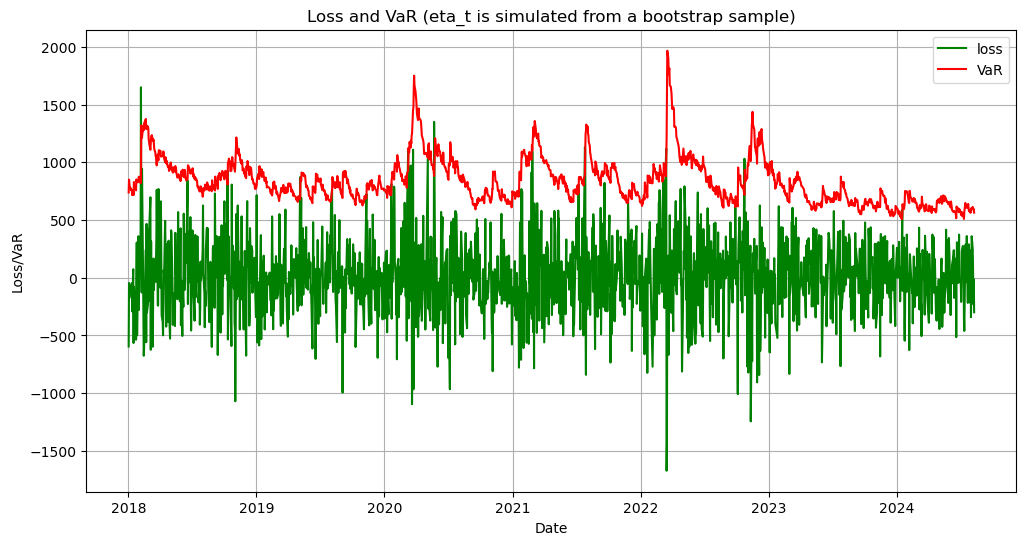

In [20]:
# #In this cell, a function for computing the standardized residuals \hat{\eta_{t}} is defined.

#Next, the function for computing VaR by determining the empirical quantile of \hat{\eta{t}} is defined.

#The graph showing the actual loss and VaR is shown.


def standardized_residuals_garch(params, returns, p, q):
    omega = params[0]
    alpha = params[1:p+1]
    beta = params[p+1: p+q+1]
    T = len(returns)
    sigma2 = np.zeros(T + max(p, q))
    epsilon = np.zeros(T + max(p, q))

    eta = np.zeros(T + max(p, q))
    
    sigma2[0: max(p, q)] = np.var(returns)
    epsilon[0: max(p, q)] = returns[0] #assume for the moment the ARMA order is (0,0) with no intercept

    returns = np.concatenate([np.zeros(max(p, q)), returns])

    for t in range(max(p, q), T + max(p, q)):
        #print("t: ", t)
        sigma2_t = omega
        for i in range(1, p + 1):
            sigma2_t += alpha[i-1] * epsilon[t-i]**2

        for j in range(1, q + 1):
            sigma2_t += beta[j-1] * sigma2[t-j]

        sigma2[t] = sigma2_t
        #print("sigma2[t]: ", sigma2[t])
        epsilon[t] = returns[t]
        eta[t] = epsilon[t]/np.sqrt(sigma2[t])
    return eta, sigma2[-p:], epsilon[-q:]

def forcast_outsample_VaR_bootstrap_garch(params, confidence, eta, insample_last_sigma2, insample_last_epsilon, insample_last_close_price, outsample, p, q):
    #eta is the standardized residual obtained from the insample.
    #insample_last_close_price is the last closing price of the insample.
    #outsample is the dataframe containing the out-of-sample.
    #p and q are garch orders.
    outsample['loss'] = -(outsample['Close']-outsample['Close'].shift(1)) 
    outsample['loss'].iloc[0] = - (outsample['Close'].iloc[0] - insample_last_close_price)

    omega = params[0]
    alpha = params[1:p+1]
    beta = params[p+1: p+q+1]
    
    T_out = len(outsample)
    if p > q:
        sigma2 = np.concatenate((insample_last_sigma2, np.zeros(T_out)))
        epsilon = np.concatenate((np.zeros(p-q), insample_last_epsilon, np.zeros(T_out)))
    elif p < q:
        sigma2 = np.concatenate((np.zeros(q-p), insample_last_sigma2, np.zeros(T_out)))
        epsilon = np.concatenate((insample_last_epsilon, np.zeros(T_out)))
    else:
        sigma2 = np.concatenate((insample_last_sigma2, np.zeros(T_out)))
        epsilon = np.concatenate((insample_last_epsilon, np.zeros(T_out)))
    qt = np.zeros(max(p,q) + T_out)
    #print(HSI_outsample['returns'])
    returns = np.concatenate((np.zeros(max(p, q)), HSI_outsample['returns']))
    
    for t in range(max(p, q), max(p, q) + T_out):
        sigma2_t = omega
        for i in range(1, p + 1):
            sigma2_t += alpha[i-1] * epsilon[t-i]**2

        for j in range(1, q + 1):
            sigma2_t += beta[j-1] * sigma2[t-j]

        sigma2[t] = sigma2_t
        #print("sigma2[t]: ", sigma2[t])
        eta_bootstrap = np.random.choice(eta, 10000, replace = True)
        #print('sqrt of sigma2[t]: ', np.sqrt(sigma2[t]))
        
        qt[t] = np.sqrt(sigma2[t]) * np.quantile(eta_bootstrap, confidence, method='inverted_cdf')
        #qt[t] = np.sqrt(sigma2[t]) * np.quantile(eta, confidence, method='inverted_cdf')
        #qt[t] = np.sqrt(sigma2[t]) * scipy.stats.norm.ppf(confidence)
        epsilon[t] = returns[t]
    print('length of outsample: ', len(outsample))
    qt = np.delete(qt, 0)
    print('length of qt: ', len(qt))
    outsample.loc[:,'qt'] = qt
    outsample.loc[:,'VaR'] = outsample['Close'].shift(1)*(1 - np.exp(outsample['qt']))
    outsample.iloc[0,outsample.columns.get_loc('VaR')] = insample_last_close_price*( 1 - np.exp(outsample['qt'].iloc[0]))
    outsample.loc[:,'violation'] = outsample.loc[:, 'loss'] > outsample.loc[:, 'VaR']
    print("number of violation: ", outsample['violation'].sum())
    print("average VaR: ", outsample['VaR'].mean())
    return outsample


eta,insample_last_sigma2, insample_last_epsilon = standardized_residuals_garch(result.x, HSI_insample['returns'].values, 1, 1)



#eta_bootstrap = np.random.choice(eta, 2000, replace = True)
#a = np.quantile(eta_bootstrap, 0.01, method='inverted_cdf')
#a
#plt.hist(eta)
#plt.hist(eta_bootstrap)
HSI_outsample = forcast_outsample_VaR_bootstrap_garch(result.x, 0.01, eta, insample_last_sigma2, insample_last_epsilon, HSI_insample['Close'].iloc[-1], HSI_outsample, 1, 1)

plt.figure(figsize=(12, 6))
plt.plot(HSI_outsample['Date'], HSI_outsample['loss'], label = 'loss', color = 'green')
plt.plot(HSI_outsample['Date'], HSI_outsample['VaR'], label = 'VaR', color = 'red')

#plt.plot(HSI_outsample['loss'], label = 'loss', color = 'green')
#plt.plot(HSI_outsample['VaR'], label = 'VaR', color = 'red')
plt.xlabel('Date')
plt.ylabel('Loss/VaR')
plt.title('Loss and VaR (eta_t is simulated from a bootstrap sample)')
plt.legend()
plt.grid(True)
plt.show()

By determining the empirical quantile of $\hat{\eta}_{t}$ (we call it GARCH-NP), the percentage of violation of VaR is close to 1%.
Next, the same comparison will be made by assuming $\hat{\eta}_{t}$ follows a standard normal distribution. We call it GARCH-$\mathcal{N}$.

C:\Users\circl\AppData\Local\Temp\ipykernel_14516\1281511315.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outsample['loss'] = -(outsample['Close']-outsample['Close'].shift(1))
C:\Users\circl\AppData\Local\Temp\ipykernel_14516\1281511315.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outsample['loss'].iloc[0] = - (outsample['Close'].iloc[0] - insample_last_close_price)


length of outsample:  1626
length of qt:  1626
number of violation:  32
average VaR:  704.3797393370153


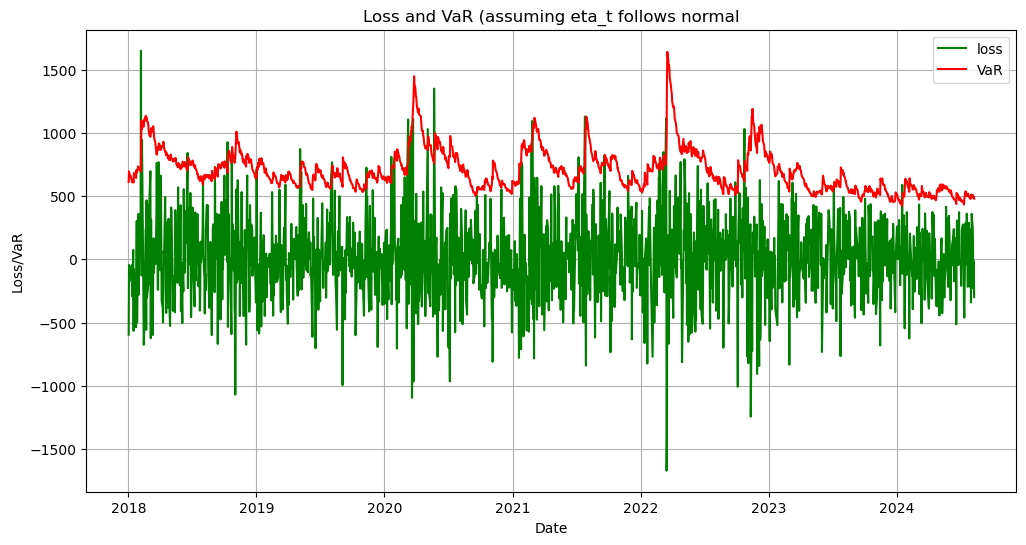

In [21]:
#Determine the quantile of epsilon_t by assuming that eta_t follows normal distribution
def forcast_outsample_VaR_normal_garch(params, confidence, eta, insample_last_sigma2, insample_last_epsilon, insample_last_close_price, outsample, p, q):
    #eta is the standardized residual obtained from the insample.
    #insample_last_close_price is the last closing price of the insample.
    #outsample is the dataframe containing the out-of-sample.
    #p and q are garch orders.
    outsample['loss'] = -(outsample['Close']-outsample['Close'].shift(1)) 
    outsample['loss'].iloc[0] = - (outsample['Close'].iloc[0] - insample_last_close_price)

    omega = params[0]
    alpha = params[1:p+1]
    beta = params[p+1: p+q+1]
    
    T_out = len(outsample)
    if p > q:
        sigma2 = np.concatenate((insample_last_sigma2, np.zeros(T_out)))
        epsilon = np.concatenate((np.zeros(p-q), insample_last_epsilon, np.zeros(T_out)))
    elif p < q:
        sigma2 = np.concatenate((np.zeros(q-p), insample_last_sigma2, np.zeros(T_out)))
        epsilon = np.concatenate((insample_last_epsilon, np.zeros(T_out)))
    else:
        sigma2 = np.concatenate((insample_last_sigma2, np.zeros(T_out)))
        epsilon = np.concatenate((insample_last_epsilon, np.zeros(T_out)))
    qt = np.zeros(max(p,q) + T_out)
    #print(HSI_outsample['returns'])
    returns = np.concatenate((np.zeros(max(p, q)), HSI_outsample['returns']))
    
    for t in range(max(p, q), max(p, q) + T_out):
        sigma2_t = omega
        for i in range(1, p + 1):
            sigma2_t += alpha[i-1] * epsilon[t-i]**2

        for j in range(1, q + 1):
            sigma2_t += beta[j-1] * sigma2[t-j]

        sigma2[t] = sigma2_t
        #print("sigma2[t]: ", sigma2[t])
        eta_bootstrap = np.random.choice(eta, 5000, replace = True)
        #print('sqrt of sigma2[t]: ', np.sqrt(sigma2[t]))
        
        #qt[t] = np.sqrt(sigma2[t]) * np.quantile(eta_bootstrap, confidence, method='inverted_cdf')
        qt[t] = np.sqrt(sigma2[t]) * scipy.stats.norm.ppf(confidence)
        epsilon[t] = returns[t]
    print('length of outsample: ', len(outsample))
    qt = np.delete(qt, 0)
    print('length of qt: ', len(qt))
    outsample.loc[:,'qt'] = qt
    outsample.loc[:,'VaR'] = outsample['Close'].shift(1)*(1 - np.exp(outsample['qt']))
    outsample.iloc[0,outsample.columns.get_loc('VaR')] = insample_last_close_price*( 1 - np.exp(outsample['qt'].iloc[0]))
    outsample.loc[:,'violation'] = outsample.loc[:, 'loss'] > outsample.loc[:, 'VaR']
    print("number of violation: ", outsample['violation'].sum())
    print("average VaR: ", outsample['VaR'].mean())
    return outsample


eta,insample_last_sigma2, insample_last_epsilon = standardized_residuals_garch(result.x, HSI_insample['returns'].values, 1, 1)



#eta_bootstrap = np.random.choice(eta, 2000, replace = True)
#a = np.quantile(eta_bootstrap, 0.01, method='inverted_cdf')
#a
#plt.hist(eta)
#plt.hist(eta_bootstrap)
HSI_outsample = forcast_outsample_VaR_normal_garch(result.x, 0.01, eta, insample_last_sigma2, insample_last_epsilon, HSI_insample['Close'].iloc[-1], HSI_outsample, 1, 1)

plt.figure(figsize=(12, 6))
plt.plot(HSI_outsample['Date'], HSI_outsample['loss'], label = 'loss', color = 'green')
plt.plot(HSI_outsample['Date'], HSI_outsample['VaR'], label = 'VaR', color = 'red')

#plt.plot(HSI_outsample['loss'], label = 'loss', color = 'green')
#plt.plot(HSI_outsample['VaR'], label = 'VaR', color = 'red')
plt.xlabel('Date')
plt.ylabel('Loss/VaR')
plt.title('Loss and VaR (assuming eta_t follows normal')
plt.legend()
plt.grid(True)
plt.show()

It can be seen that the GARCH-NP method has the percentage of loss violating the estimated VaR close to 1%.
On the other hand, the GARCH-$\mathcal{N}$ has the percentage of violation close to 2%. It is not surprising since the empirical distribution of the return series is very far from Gaussian.

For the cost, obviously the GARCH-NP has a higher cost while the GARCH-$\mathcal{N}$ method has a lower cost.

Next, two other methods will be used to estimate 1-day VaR: historical VaR and RiskMetrics.

In historical VaR, the 1%-th quantile of last 250 daily returns is taken to compute the 1-day VaR. To estimate the VaR's over the whole out-of-sample period, a moving window of size 250 is used for obtaining the 1%-th quantile.

RiskMetrics employs a special case of GARCH with a single parameter in the volatility equation:
$$\sigma_{t}^{2} = \lambda\sigma_{t-1}^{2} + (1-\lambda)\epsilon_{t-1}^{2}.$$
A reasonable choice of the smoothing parameter $\lambda$ is 0.94.

T_in:  1816
T_out:  1626
           Date          Open          High           Low         Close  \
1829 2018-01-02  30028.289063  30515.310547  30028.289063  30515.310547   
1830 2018-01-03  30658.730469  30724.320313  30456.759766  30560.949219   
1831 2018-01-04  30691.710938  30796.929688  30560.429688  30736.480469   
1832 2018-01-05  30893.859375  30911.009766  30638.529297  30814.640625   
1833 2018-01-08  30895.089844  30929.150391  30732.539063  30899.529297   
...         ...           ...           ...           ...           ...   
3450 2024-08-05  16676.820313  16944.589844  16441.439453  16698.359375   
3451 2024-08-06  16861.300781  16908.970703  16611.140625  16647.339844   
3452 2024-08-07  16684.779297  16988.259766  16684.779297  16877.859375   
3453 2024-08-08  16773.039063  17023.099609  16665.060547  16891.830078   
3454 2024-08-09  17097.359375  17252.220703  17082.599609  17191.429688   

         Adj Close        Volume   returns        loss        qt         V

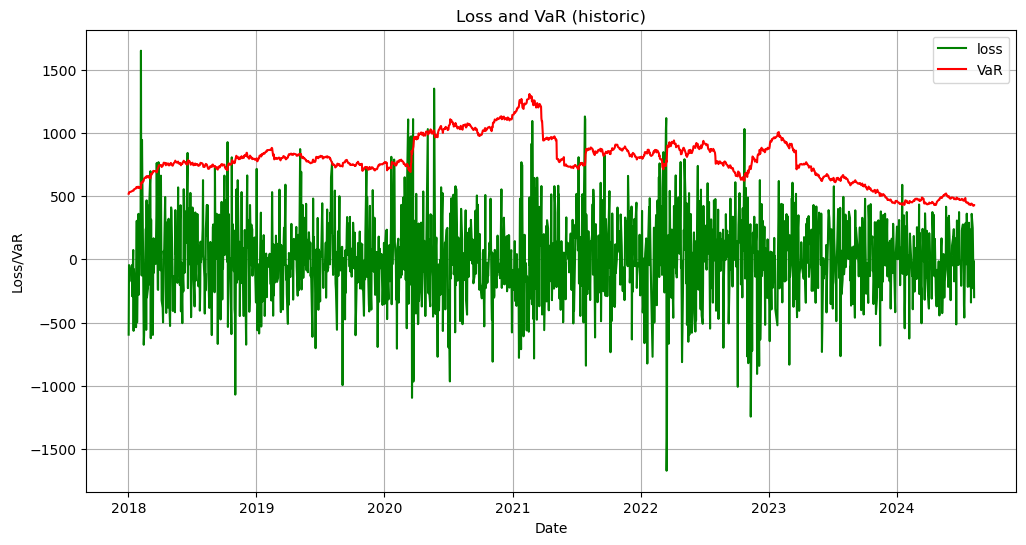

In [22]:

def forcast_outsample_VaR_historic(confidence, full_sample, insample, outsample, K):
    #eta is the standardized residual obtained from the insample.
    #insample_last_close_price is the last closing price of the insample.
    #outsample is the dataframe containing the out-of-sample.
    #p and q are garch orders.
    full_sample['loss'] = -(full_sample['Close']-full_sample['Close'].shift(1))
    T_in = len(insample)
    
    T_out = len(outsample)
    
    full_sample['qt'] = full_sample['returns'].shift(1).rolling(K).quantile(confidence)
    full_sample.loc[:,'VaR'] = full_sample['Close'].shift(1)*(1 - np.exp(full_sample['qt']))
    full_sample.loc[:,'violation'] = full_sample.loc[:, 'loss'] > full_sample.loc[:, 'VaR']
    print("T_in: ", T_in)
    print("T_out: ", T_out)
    outsample = full_sample.iloc[T_in:T_in + T_out]
    print(outsample)
    print("number of violation: ", outsample['violation'].sum())
    print("average VaR: ", outsample['VaR'].mean())
    return outsample



#eta_bootstrap = np.random.choice(eta, 2000, replace = True)
#a = np.quantile(eta_bootstrap, 0.01, method='inverted_cdf')
#a
#plt.hist(eta)
#plt.hist(eta_bootstrap)
HSI_outsample = forcast_outsample_VaR_historic(0.01, HSI, HSI_insample, HSI_outsample, 250)

plt.figure(figsize=(12, 6))
plt.plot(HSI_outsample['Date'], HSI_outsample['loss'], label = 'loss', color = 'green')
plt.plot(HSI_outsample['Date'], HSI_outsample['VaR'], label = 'VaR', color = 'red')

#plt.plot(HSI_outsample['loss'], label = 'loss', color = 'green')
#plt.plot(HSI_outsample['VaR'], label = 'VaR', color = 'red')
plt.xlabel('Date')
plt.ylabel('Loss/VaR')
plt.title('Loss and VaR (historic)')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\circl\AppData\Local\Temp\ipykernel_14516\304186026.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outsample['loss'] = -(outsample['Close']-outsample['Close'].shift(1))
C:\Users\circl\AppData\Local\Temp\ipykernel_14516\304186026.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outsample['loss'].iloc[0] = - (outsample['Close'].iloc[0] - insample_last_close_price)


length of outsample:  1626
length of qt:  1626
number of violation:  33
average VaR:  732.2365083470531


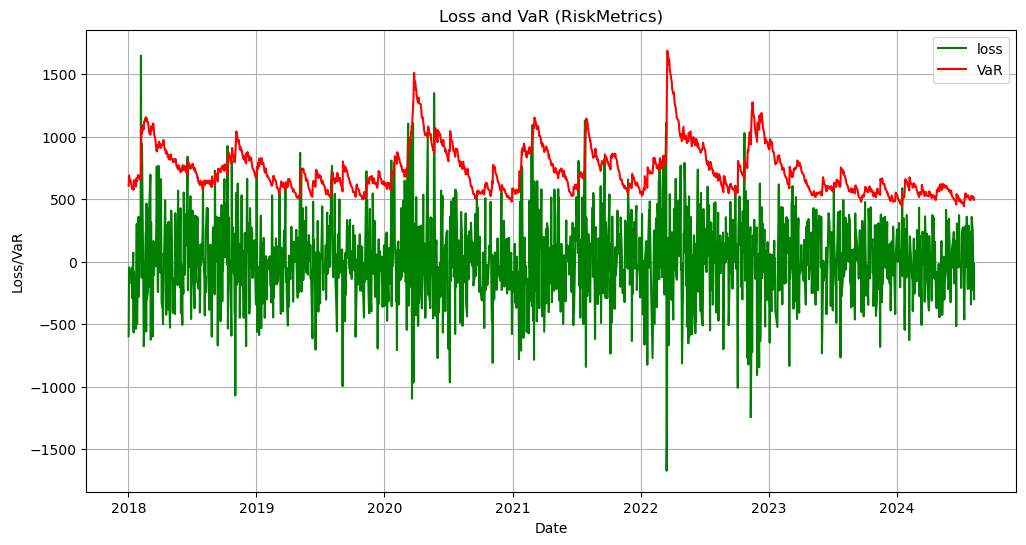

In [23]:

def forcast_outsample_VaR_RiskMetrics(lambda_, confidence, eta, insample_last_sigma2, insample_last_epsilon, insample_last_close_price, outsample):
    #eta is the standardized residual obtained from the insample.
    #insample_last_close_price is the last closing price of the insample.
    #outsample is the dataframe containing the out-of-sample.
    #p and q are garch orders.
    outsample['loss'] = -(outsample['Close']-outsample['Close'].shift(1)) 
    outsample['loss'].iloc[0] = - (outsample['Close'].iloc[0] - insample_last_close_price)
    
    T_out = len(outsample)

    sigma2 = np.concatenate((insample_last_sigma2, np.zeros(T_out)))
    epsilon = np.concatenate((insample_last_epsilon, np.zeros(T_out)))
    qt = np.zeros(1 + T_out)
    #print(HSI_outsample['returns'])
    returns = np.concatenate((np.zeros(1), HSI_outsample['returns']))
    
    for t in range(1, 1 + T_out):
        sigma2_t = 0
        for i in range(1, 1 + 1):
            sigma2_t += (1-lambda_) * epsilon[t-i]**2

        for j in range(1, 1 + 1):
            sigma2_t += lambda_ * sigma2[t-j]

        sigma2[t] = sigma2_t
        #print("sigma2[t]: ", sigma2[t])
        eta_bootstrap = np.random.choice(eta, 5000, replace = True)
        #print('sqrt of sigma2[t]: ', np.sqrt(sigma2[t]))
        
        #qt[t] = np.sqrt(sigma2[t]) * np.quantile(eta_bootstrap, confidence, method='inverted_cdf')
        qt[t] = np.sqrt(sigma2[t]) * scipy.stats.norm.ppf(confidence)
        epsilon[t] = returns[t]
    print('length of outsample: ', len(outsample))
    qt = np.delete(qt, 0)
    print('length of qt: ', len(qt))
    outsample.loc[:,'qt'] = qt
    outsample.loc[:,'VaR'] = outsample['Close'].shift(1)*(1 - np.exp(outsample['qt']))
    outsample.iloc[0,outsample.columns.get_loc('VaR')] = insample_last_close_price*( 1 - np.exp(outsample['qt'].iloc[0]))
    outsample.loc[:,'violation'] = outsample.loc[:, 'loss'] > outsample.loc[:, 'VaR']
    print("number of violation: ", outsample['violation'].sum())
    print("average VaR: ", outsample['VaR'].mean())
    return outsample


eta,insample_last_sigma2, insample_last_epsilon = standardized_residuals_garch(result.x, HSI_insample['returns'].values, 1, 1)



#eta_bootstrap = np.random.choice(eta, 2000, replace = True)
#a = np.quantile(eta_bootstrap, 0.01, method='inverted_cdf')
#a
#plt.hist(eta)
#plt.hist(eta_bootstrap)
HSI_outsample = forcast_outsample_VaR_RiskMetrics(0.94, 0.01, eta, insample_last_sigma2, insample_last_epsilon, HSI_insample['Close'].iloc[-1], HSI_outsample)

plt.figure(figsize=(12, 6))
plt.plot(HSI_outsample['Date'], HSI_outsample['loss'], label = 'loss', color = 'green')
plt.plot(HSI_outsample['Date'], HSI_outsample['VaR'], label = 'VaR', color = 'red')

#plt.plot(HSI_outsample['loss'], label = 'loss', color = 'green')
#plt.plot(HSI_outsample['VaR'], label = 'VaR', color = 'red')
plt.xlabel('Date')
plt.ylabel('Loss/VaR')
plt.title('Loss and VaR (RiskMetrics)')
plt.legend()
plt.grid(True)
plt.show()

Summary of VaR violation of different estimation method:

|               | Historic | Risk metrics | GARCH-$\mathcal{N}$ | GARCH-NP |
| :---------------- | :------: | ----: |:------: |:------: |
| Number of losses > VaR        |   27   | 33 | 32 | 16 |
| Average estimated VaR           |   784.82   | 732.24 | 704.38 | 839.27 |

There are 1626 observations in the out-of-sample data set. Of these estimation methods, only GARCH-NP adequately controls the level 1%, which is not surprising since the empirical distribution of the return is very far from Gaussian.

These results do not allow us to draw any definitive conclusions, but the Riskmetrics appears to be outperformed by GARCH-$\mathcal{N}$: The numbers of violations of these two methods are very close but the average VaR (cost) of Riskmetrics is higher than that of GARCH-$\mathcal{N}$.

In [ ]:
# calculate squared eta, and autocorrelation, not finished

def squared(params, returns, p, q):
    omega = params[0]
    alpha = params[1:p+1]
    beta = params[p+1: p+q+1]
    T = len(returns)
    sigma2 = np.zeros(T + max(p, q))
    epsilon = np.zeros(T + max(p, q))
    
    log_likelihood = 0
    
    sigma2[0: max(p, q)] = np.var(returns)
    epsilon[0: max(p, q)] = returns[0] #assume for the moment the ARMA order is (0,0) with no intercept

    returns = np.concatenate([np.zeros(max(p, q)), returns])

    log_likelihood = 0
    for t in range(max(p, q), T + max(p, q)):
        #print("t: ", t)
        sigma2_t = omega
        for i in range(1, p + 1):
            sigma2_t += alpha[i-1] * epsilon[t-i]**2

        for j in range(1, q + 1):
            sigma2_t += beta[j-1] * sigma2[t-j]

        sigma2[t] = sigma2_t
        #print("sigma2[t]: ", sigma2[t])
        epsilon[t] = returns[t]
        #print("epsilon[t[: ", epsilon[t])
        #print("")
        log_likelihood += -0.5 * (np.log(2 * np.pi) + np.log(sigma2[t]) + (epsilon[t]**2 / sigma2[t]))

    return -log_likelihood



p = 1
q = 1

initial_params = [0.000003] + [0.05]*p + [0.93]*q

bounds = [ (1e-6, None) ] + [(0, 1)]*p + [(0, 1)]*q

#garch_log_likelihood_grad = grad(garch_log_likelihood)

#garch_log_likelihood_hess = hessian(garch_log_likelihood)

returns_array = HSI["returns"].values

log_likelihood = garch_log_likelihood(initial_params, returns_array, p, q)



# minimize the negative of log-likelihood
result = minimize(garch_log_likelihood, initial_params, args=(returns_array, p, q), method='L-BFGS-B', bounds=bounds)

# Estimated parameters
estimated_params = result.x
omega_est, alpha_est, beta_est = estimated_params
print("Estimated parameters:", estimated_params)

# Compute standard errors of the estimates
# The standard errors can be approximated from the Hessian matrix
hessian_inv = result.hess_inv.todense()
std_errors = np.sqrt(np.diag(hessian_inv))
print("Standard errors:", std_errors)

# Print the results
print(f"Estimated omega: {omega_est}, Standard Error: {std_errors[0]}")
print(f"Estimated alpha: {alpha_est}, Standard Error: {std_errors[1]}")
print(f"Estimated beta: {beta_est}, Standard Error: {std_errors[2]}")

print(f"success: {result.success}")
print(f"message: {result.message}")
print(f"jac: {result.jac}")

maximized_loglikelihood = garch_log_likelihood(result.x, returns_array, p, q)
print(f"Maximized log-likelihood value: {maximized_loglikelihood}")